In [1]:
2

2

In [2]:
# import hdf5plugin, h5py
import torch, tables
from torch import nn
import os
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from functools import partial
from tqdm.notebook import tqdm
from typing import Any
import torchvision
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
from dataclasses import dataclass
from typing import Callable
import cv2, functools, glia

import torch.nn

/home/tyler/.conda/envs/torch/lib/python3.8/site-packages/pkg_resources/__init__.py:1149: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  return get_provider(package_or_requirement).get_resource_stream(


In [3]:
import mlflow

from pytorch_lightning.loggers import MLFlowLogger

/home/tyler/.conda/envs/torch/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# directory = "/storage/uw/3brain/200623_faces/"
# name = "R1_E3_AMES_200min_200f_14l_rgb.h5"
# used for logging
# data_URI = "200623_faces/R1_E3_AMES_200min_200f_14l_rgb.h5"
directory = "/data/uw/200807_ffhq/"
# directory = "/scratch"
# name = "R1_E1_AMES_160min_ffhq_0_2501.h5
name = "R1_E4_AMES_640min_ffhq_0_5000.h5"

hdf5 = tables.open_file(os.path.join(directory,name),'r')
h5 = hdf5.root
# h5 = h5py.File(os.path.join(directory,f),'r', swmr=True)

In [5]:
h5["data"][:10].sum()

35727

In [6]:
nExamples, nTime, nRow, nCol, nUnitChannels = h5["data"].shape
h5

/ (RootGroup) ''
  children := ['data' (CArray), 'image_classes' (CArray), 'images' (CArray), 'target' (CArray)]

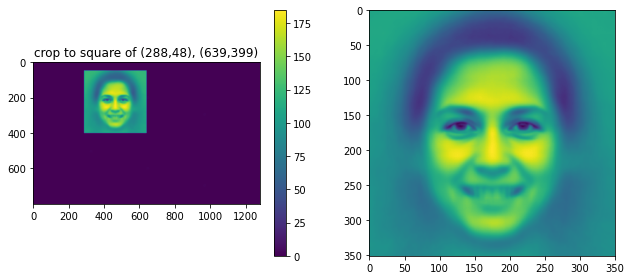

In [7]:
imgs = h5["images"][0:1000]

avg_img = np.mean(imgs, axis=(0,3))

y,x = np.where(avg_img>5)

xleft = min(x)
xright = max(x)
ytop = min(y)
ybot = max(y)

plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(avg_img)
plt.colorbar()
plt.title(f"crop to square of ({xleft},{ytop}), ({xright},{ybot})")
plt.subplot(122)
plt.imshow(avg_img[ytop:ybot,xleft:xright])
plt.tight_layout()

In [8]:
def resize_3d(images, fx, fy, interpolation=cv2.INTER_LINEAR, out="ndarray",
        is_tiff=False):
    im = cv2.resize((images[0]), None, fx=fx, fy=fy, interpolation=interpolation)
    if out=="ndarray":
        new = np.zeros([images.shape[0], *im.shape],
            dtype = np.float32)
    elif out=="memmap":
        new = np.memmap("glia_temp_memmap.mmap", np.float32, "w+",
            (images.shape[0], im.shape[0],im.shape[1]))
    for z, img in enumerate(images):
        new[z] = cv2.resize((img), None, fx=fx, fy=fy,
            interpolation=interpolation)
    return new

def gray_3d(images):
    im = cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)
    new = np.zeros([images.shape[0], *im.shape],
            dtype = np.float32)
    for z, img in enumerate(images):
        new[z] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return new



@dataclass
class ImageData(Dataset):
    original_images:tables.carray.CArray
#     h5_path:str
#     dset_path:str = "images"
    H:int = 64 # resize to this
    W:int = 64
    convert_to_gray:bool = True
    zero_to_one:bool = True
    interpolation:Callable = cv2.INTER_LINEAR
    crop:Any = None
    
    def __post_init__(self):
        oH, oW = self.original_images.shape[1:3]
        crop = self.crop
        if crop:
            images = self.original_images[:,crop[0]:crop[1],crop[2]:crop[3]]
            oH, oW = images.shape[1:3]
        else:
            images = self.original_images
        self.images = resize_3d(images,
            fx=self.W/oW, fy=self.H/oH, interpolation=self.interpolation)
        if self.convert_to_gray:
            self.images = gray_3d(self.images)[...,None]
        if self.zero_to_one:
            self.images /= 255

        
    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, i):
        im = transforms.functional.to_tensor(self.images[i])
        return im
    
@dataclass
class RetinaData(Dataset):
    # we use HDF5 for compression of sparse data
    # otherwise, RAM would blow up. But after binning, not so large
    retina_data:tables.carray.CArray
    nbins:int = 10
        # collapse units into channel
    no_units:bool = False
    def __post_init__(self):
        slices = np.linspace(0, self.retina_data.shape[1], self.nbins+1, True).astype(np.int)
        bin_func = partial(np.add.reduceat, indices=slices[:-1], axis=0, dtype=np.float32)
        # THWC
        binned = np.array(glia.pmap(bin_func, self.retina_data, progress=True))
        # TCHW
        binned = torch.from_numpy(np.moveaxis(binned,-1,2))
        if self.no_units:
            binned = binned.sum(2, keepdims=True)
        self.data = binned
        
    def __len__(self):
        return self.retina_data.shape[0]
    def __getitem__(self,i):
        return self.data[i]

image_dset = ImageData(h5["images"], crop=[ytop,ybot,xleft,xright])
retina_dset = RetinaData(h5["data"], no_units=False)
(image_dset[0].shape, retina_dset[0].shape)

(torch.Size([1, 64, 64]), torch.Size([10, 6, 64, 64]))

In [9]:
class ConcatDataset(torch.utils.data.Dataset):
    "Combine multiple datasets as tuples."
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)


@dataclass
class ImageRetina(pl.LightningDataModule):
    images_dset:Dataset
    retina_dset:Dataset
    batch_size:int = 64
    # must be single-thread or else BLOSC barfs
    num_workers:int = 8

    def __post_init__(self):
        super().__init__()
        concat_dataset = ConcatDataset(
            self.images_dset, self.retina_dset
        )
        N = len(self.images_dset)
        ntrain = int(N*0.8)
        nval = int(N*0.1)
        ntest = N-ntrain-nval
        lengths = [ntrain, nval, ntest]
        self.train, self.val, self.test = random_split(concat_dataset, lengths,
               generator=torch.Generator().manual_seed(42))
        
    def train_dataloader(self):
        
        loader = torch.utils.data.DataLoader(
            self.train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            pin_memory=True
        )
        return loader

    def val_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.val,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True
        )
        return loader

    def test_dataloader(self):
        loader = torch.utils.data.DataLoader(
            self.test,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True
        )
        return loader

## Standard loss functions

## VAE

In [10]:
from pathlib import Path
Path("ffhq_viz").mkdir(exist_ok=True)

## Conv decoder

In [13]:
T = 5
H = 8
W = 8
C = 3
nct = 4

r = np.ones((T,C,H,W))
pr = np.ones([nct,C,H,W])
pr[0] = 1
pr[1] = 0

o = np.einsum("tchw,nchw->tnhw",r,pr)
assert o[:,0].sum() > 1
assert o[:,1].sum() == 0

In [14]:
def convLayer(in_chan, out_chan, kernel=9):
    return nn.Conv2d(in_chan, out_chan, kernel_size=kernel,
                     padding=kernel//2, bias=False)

class BasicBlock(nn.Module):

    def __init__(self, in_chan, out_chan, nonlinearity=F.relu):
        super(BasicBlock, self).__init__()
        self.conv1 = convLayer(in_chan, out_chan)
        self.bn1 = nn.BatchNorm2d(out_chan)
        self.nonlinearity = nonlinearity
        self.conv2 = convLayer(out_chan, out_chan)
        self.bn2 = nn.BatchNorm2d(out_chan)

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.nonlinearity(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += residual
        out = self.nonlinearity(out)

        return out

In [15]:
# Now working very well!
# this is just a plain nn.Module with some structure
@dataclass(unsafe_hash=True)
class ConvDecoder(pl.LightningModule):
    "Given retina firing rates, reconstruct image"
    imageChannels:int = 3
    nUnitChannels:int = nUnitChannels
    nBlockChannels:int = 16
    meaH:int = 64
    meaW:int = 64
    H:int = 64
    W:int = 64
    # joint hyperparam with data preprocessing (eg binning)
    nTimeSteps:int = 10
    # hyperparams
    nCelltypes:int = 8 # used for local linear layer
    kernel1:int = 15
    kernel2:int = 9
    lr:float = 1e-4
    beta:float = 1
    nonlinearity:Callable = F.relu
    out_folder:str = "ffhq_viz"
    model_name:str = "ConvDecoder"
    nLayers = 4
    save_model = False
    example_input_array:T.FloatTensor = retina_dset[0]
        
    def __post_init__(self):
        super().__init__()
        
        # TODO: loss of 1 - l2 norm on weights to encourage winner-takes-all
        cl = torch.FloatTensor(
            self.nCelltypes, self.nUnitChannels, self.meaH, self.meaW).fill_(
            1/self.nCelltypes)
        self.celltype_likelihood = nn.Parameter(cl) # uniform prior

        self.conv1 = nn.Conv2d(in_channels=self.nCelltypes*self.nTimeSteps,
            out_channels=self.nBlockChannels, kernel_size=self.kernel1,
            padding=self.kernel1//2)
        self.bn1 = nn.BatchNorm2d(self.nBlockChannels)
        layers = [BasicBlock(self.nBlockChannels, self.nBlockChannels, self.nonlinearity)
                  for i in range(self.nLayers)]
        conv2 = nn.Conv2d(in_channels=self.nBlockChannels,
            out_channels=self.imageChannels, kernel_size=self.kernel2,
            padding=self.kernel2//2)
        layers.append(conv2)
        self.layers = nn.Sequential(*layers)
        
#         self.save_hyperparameters()
        
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
    
    def forward(self,x):
        "Retina -> Image response"
        # map each unit to canonical celltype
#         prob = F.softmax(self.celltype_likelihood, dim=0)
        if self.training:
            x = torch.poisson(x)
        x = torch.einsum("btchw,nchw->btnhw", x, self.celltype_likelihood)
        # combine time and unit dimensions
        x = x.view(-1,self.nTimeSteps*self.nCelltypes, self.meaH, self.meaW)
        x = self.conv1(x)
        x = self.nonlinearity(self.bn1(x))
        x = self.layers(x)
        x = self.nonlinearity(x)
#         x = F.softmax(x)
        return x
        
    def calc_loss(self, batch, batch_idx):
        images, retina = batch
        im_pred = self(retina)
        recon_loss = F.mse_loss(im_pred, images, reduction='sum') / images.shape[0]
#         recon_loss = F.binary_cross_entropy(im_pred, images, reduction='sum') / images.shape[0]
        # encourage celltype prob to collapse onto single type
#         celltype_loss = (1 - F.softmax(self.celltype_likelihood,dim=0).norm(dim=0)).mean()
        celltype_loss = (1 - self.celltype_likelihood.norm(dim=0)).mean()
#         loss = self.beta * celltype_loss + recon_loss
        loss = recon_loss
        return {"loss": loss, "recon_loss": recon_loss, "celltype_loss": celltype_loss,
                "im_pred": im_pred}

    def training_step(self, batch, batch_idx):
        loss_dict = self.calc_loss(batch, batch_idx)
        loss, recon_loss, celltype_loss = loss_dict["loss"], \
            loss_dict["recon_loss"], loss_dict["celltype_loss"]
        result = pl.TrainResult(loss)
        result.log('train_loss', loss, prog_bar=True)
        result.log('reconstruction_loss', recon_loss, prog_bar=True)
        result.log('celltype_loss', celltype_loss, prog_bar=True)
        return result
        
    def validation_step(self, batch, batch_idx):
        loss_dict = self.calc_loss(batch, batch_idx)
        loss, recon_loss, celltype_loss, Y_pred = loss_dict["loss"], \
            loss_dict["recon_loss"], loss_dict["celltype_loss"], loss_dict["im_pred"]
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_loss', loss, on_epoch=True)
        result.log('val_reconstruction_loss', recon_loss, on_epoch=True)
        result.log('val_celltype_loss', celltype_loss, on_epoch=True)
        
        Y, _ = batch
        
        if batch_idx==0:
            epoch = trainer.current_epoch
            n = min(Y.size(0), 15)
            comparison = torch.cat([Y[:n].view(-1,1,self.H,self.W),
                               Y_pred[:n].view(-1,1,self.H,self.W)])
            torchvision.utils.save_image(comparison,
                     self.out_folder+f'/{name}_reconstruction_' + str(epoch) + '.png', nrow=n)
        return result
    
    def
    
    def test_step(self, batch, batch_idx):
        loss_dict = self.calc_loss(batch, batch_idx)
        
        return result

    def training_epoch_end(self, outputs):
        train_loss_mean = outputs['train_loss'].mean().item()
        self.logger.log_metrics({"epoch_train_loss": train_loss_mean},
                                trainer.current_epoch)
        return outputs
        
    def image_out_paths(self, epoch):
        recon = self.out_folder+f'/{name}_reconstruction_' + str(epoch) + '.png'
        sample = self.out_folder+'/sample_' + str(epoch) + '.png'
        return recon, sample
    
    def validation_epoch_end(self, outputs):
        # see https://github.com/PyTorchLightning/pytorch-lightning/issues/914
        # for discussion
        loss_mean = outputs['val_loss'].mean().item()
        recon_mean = outputs['val_reconstruction_loss'].mean().item()
        celltype_mean = outputs['val_celltype_loss'].mean().item()
        e = trainer.current_epoch
        self.logger.log_metrics({"epoch_val_loss": loss_mean},
                                e)
        if (trainer.current_epoch != 0) and (trainer.current_epoch % 20 == 0):
            # TODO use PTL to automate saving of only best validation model?
            # only save images from best model??
            checkpoint_path = os.path.join(self.out_folder, f"epoch_{e}.ckpt")
            recon_path, sample_path = self.image_out_paths(e)
#             run_id = self.logger.run_id
#             self.logger.experiment.log_artifact(run_id, recon_path, f"images/reconstruction_{e}.png")
#             if self.save_model:
#                 trainer.save_checkpoint(checkpoint_path)
#                 self.logger.experiment.log_artifact(run_id, checkpoint_path, f"models/epoch_{e}.ckpt")
        outputs['val_loss'] = loss_mean
        outputs['val_reconstruction_loss'] = recon_mean
        outputs['val_celltype_loss'] = celltype_mean
        return outputs

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-3)
    
epoch = 0
!mkdir -p ffhq_viz && rm -rf ffhq_viz/*
    
dm = ImageRetina(image_dset, retina_dset,batch_size=64)
model = ConvDecoder(imageChannels=1, lr=1e-4, beta=1, nonlinearity=F.relu)
mlf_logger = MLFlowLogger(
    experiment_name="glia",
    tracking_uri="https://mlflow.tylerbenster.com/"
)
# trainer = pl.Trainer(gpus=[0], logger=mlf_logger)#, auto_lr_find=True)#, gradient_clip_val=0.5)
trainer = pl.Trainer(gpus=[0], auto_lr_find=True)

trainer.fit(model, dm)
trainer.test(datamodule=dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type        | Params
---------------------------------------
0 | conv1  | Conv2d      | 288 K 
1 | bn1    | BatchNorm2d | 32    
2 | layers | Sequential  | 167 K 


Saving latest checkpoint..
LR finder stopped early due to diverging loss.
Learning rate set to 0.0010964781961431851
/home/tyler/.conda/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Could not log computational graph since the `model.example_input_array` attribute is not set or `input_array` was not given
  warnings.warn(*args, **kwargs)

  | Name   | Type        | Params
---------------------------------------
0 | conv1  | Conv2d      | 288 K 
1 | bn1    | BatchNorm2d | 32    
2 | layers | Sequential  | 167 K 


/home/tyler/.conda/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: you passed in a test_dataloader but have no test_step. Skipping test loop
  warnings.warn(*args, **kwargs)
LR finder stopped early due to diverging loss.
/home/tyler/.conda/envs/torch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: You're resuming from a checkpoint that ended mid-epoch. This can cause unreliable results if further training is done, consider using an end of epoch checkpoint. 
  warnings.warn(*args, **kwargs)
Failed to compute suggesting for `lr`. There might not be enough points.
Traceback (most recent call last):
  File "/home/tyler/.conda/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/lr_finder.py", line 352, in suggestion
    min_grad = np.gradient(loss).argmin()
  File "<__array_function__ internals>", line 5, in gradient
  File "/home/tyler/.conda/envs/torch/lib/python3.8/site-packages/numpy/

TypeError: '<=' not supported between instances of 'float' and 'NoneType'

In [28]:
trainer.save_checkpoint("ConvDecoder_epoch999.ckpt")

In [27]:
trainer.test(model)

1

In [23]:
model.lr = 1e-3

# Retina AE

In [ ]:
# not yet complete
# this is just a plain nn.Module with some structure
@dataclass(unsafe_hash=True)
class RetinaAutoEncoder(pl.LightningModule):
    "Given image, output both retina firing rates + reconstruction"
    imageChannels:int = 3
    nUnitChannels:int = nUnitChannels
    meaH:int = 64
    meaW:int = 64
    # joint hyperparam with data preprocessing (eg binning)
    nTimeSteps:int = 10
    # hyperparams
    conv1_out:int = 8
    conv2_out:int = 8
#     nCelltypes:int = 8
    dconv1_out:int = 8
    dconv2_out:int = 8
    kernel1:int = 15
    kernel2:int = 15
    kernel3:int = 15
    recon_lambda:float = 1
    lr:float = 1e-3
    nonlinearity:Callable = F.relu
        
    def __post_init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=self.imageChannels,
            out_channels=self.conv1_out, kernel_size=self.kernel1,
            padding=self.kernel1//2)
        self.conv2 = nn.Conv2d(in_channels=self.conv1_out,
            out_channels=self.conv2_out, kernel_size=self.kernel2,
            padding=self.kernel2//2)
        c = self.nUnitChannels * self.nTimeSteps # add time dimension
        # output of conv3 is good place to interpret cell types
        self.conv3 = nn.Conv2d(in_channels=self.conv2_out,
            out_channels=c,kernel_size=self.kernel3,
            padding=self.kernel3//2)
        
        # TODO: loss of 1 - l2 norm on weights to encourage winner-takes-all
#         self.celltype = LocalLinear(c)

        self.dconv1 = nn.Conv2d(in_channels=c,out_channels=self.dconv1_out,
                                kernel_size=self.kernel1,
                                padding=self.kernel1//2)
        self.dconv2 = nn.Conv2d(in_channels=self.dconv1_out,
            out_channels=self.dconv2_out, kernel_size=self.kernel2,
            padding=self.kernel2//2)
        # back to RGB
        self.dconv3 = nn.Conv2d(in_channels=self.dconv2_out,
            out_channels=self.imageChannels, kernel_size=self.kernel3,
            padding=self.kernel3//2)
        
        for l in [self.conv1, self.conv2, self.conv3, self.dconv1, self.dconv2, self.dconv3]:
            nn.init.kaiming_normal_(l.weight)
#         self.save_hyperparameters()
        
    def encode(self,x):
        "Image -> Retina response"
        x = self.nonlinearity(self.conv1(x))
        x = self.nonlinearity(self.conv2(x))
        x = self.nonlinearity(self.conv3(x))
        # reshape to Batch x Time x Units x MEA Row x MEA Col
        return x.reshape(-1,self.nTimeSteps,self.nUnitChannels,self.meaH,self.meaW)
    
    def decode(self,x):
        "Retina -> Image response"
        x = x.reshape(-1, self.nTimeSteps*self.nUnitChannels, self.meaH, self.meaW)
        x = self.nonlinearity(self.dconv1(x))
        x = self.nonlinearity(self.dconv2(x))
        x = self.nonlinearity(self.dconv3(x))
        return x
        
    def forward(self, x):
        retina_pred = self.encode(x)
        reconstruction = self.decode(retina_pred)
        return {"retina": retina_pred, "reconstruction": reconstruction}
    
    def calc_loss(self, batch, batch_idx):
        images, retina = batch
        out = self(images)
        # TODO remove this line after debugging why reconstruction loss goes to nan...
        print(f'{out["reconstruction"].mean()=}, {retina.mean()=}, {images.mean()=}')
        recon_loss = F.mse_loss(out["reconstruction"], images, reduction='mean')
        retina_loss = F.poisson_nll_loss(out["retina"], retina, reduction='mean')
        loss = self.recon_lambda * recon_loss + retina_loss
        return loss, recon_loss, retina_loss

    def training_step(self, batch, batch_idx):
        loss, recon_loss, retina_loss = self.calc_loss(batch, batch_idx)
        result = pl.TrainResult(loss)
        result.log('train_loss', loss, prog_bar=True)
        result.log('reconstruction_loss', recon_loss, prog_bar=True)
        result.log('retina_loss', retina_loss, prog_bar=True)
        return result
        
    def validation_step(self, batch, batch_idx):
        loss, recon_loss, retina_loss = self.calc_loss(batch, batch_idx)
        result = pl.EvalResult(checkpoint_on=loss)
        result.log('val_loss', loss, on_epoch=True)
        result.log('val_reconstruction_loss', recon_loss, on_epoch=True)
        result.log('val_retina_loss', retina_loss, on_epoch=True)
        return result

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    

dm = ImageRetina(image_dset, retina_dset,batch_size=32)
model = RetinaAutoEncoder(imageChannels=1, lr=1e-8)
trainer = pl.Trainer(gpus=[1], gradient_clip_val=0.5)
trainer.fit(model, dm)
trainer.test(datamodule=dm)